In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

import sim_lib.graph as graph
import sim_lib.graph_create as gc
import sim_lib.graph_networkx as gnx
import sim_lib.util as util

In [2]:
_N = 5
_M = 5

_HO_THRESH = 0.0
_NUM_GROUPS = 3 # Number of discrete groups person can belong in

_RW_LENGTH = 5 # Length of random walk when adding vertex

_COLOR_LIST = ['c', 'y', 'm', 'b']

In [3]:
def has_edge(u, v, attr_dict):

    # Meets homophily requirement
    if attr_dict[u]['g'] == attr_dict[v]['g']:
        return abs(attr_dict[u][3] - attr_dict[v][3]) > _HO_THRESH

    # Differential filter
    attr1_diff = attr_dict[u][1] - attr_dict[v][1]
    attr2_diff = attr_dict[u][2] - attr_dict[v][2]
    if attr1_diff * attr2_diff > 0:
        return False
    return np.random.random() < np.sqrt((attr1_diff ** 2) + (attr2_diff ** 2)) / np.sqrt(2)

def attribute_block_graph(n):
    vtx_set = []
    attr_dict = {}

    for i in range(n):
        vtx = graph.Vertex(0, 0, {0 : 0}, i)
        attr_dict[vtx] = { 1 : np.random.random(),
                2 : np.random.random(),
                3 : np.random.random(),
                'g' : np.random.randint(0, _NUM_GROUPS) }
        vtx_set.append(vtx)

    G = graph.Graph()
    G.vertices = vtx_set
    
    # Within community
    for u in G.vertices:
        for v in G.vertices:
            if u.vnum == v.vnum:
                continue
            if has_edge(u, v, attr_dict):
                G.add_edge(u, v, 1)

    G.data = attr_dict
    return G

In [4]:
def add_attr_graph_vtx(G, v, rw_len):
    G.data[v] = { 1 : np.random.random(),
                  2 : np.random.random(),
                  3 : np.random.random(),
                  'g' : np.random.randint(0, _NUM_GROUPS) }
    
    # Find vertex with closest homophily value
    in_group_vtxs = [ u for u in G.vertices if G.data[u]['g'] == G.data[v]['g'] ]
    hp_abs_diffs = { u : abs(G.data[u][3] - G.data[v][3]) for u in in_group_vtxs }
    
    init_vtx = min(hp_abs_diffs, key=hp_abs_diffs.get)
    G.add_edge(v, init_vtx, 1)
    
    # Start random walk
    cur_vtx = init_vtx
    for _ in range(rw_len):
        cur_vtx = cur_vtx.nbors[np.random.randint(0, cur_vtx.degree)]
        if (v in cur_vtx.edges) and (cur_vtx in v.edges):
            continue
        if has_edge(v, cur_vtx, G.data):
            G.add_edge(v, cur_vtx, 1)
    G.vertices.append(v)
    return init_vtx

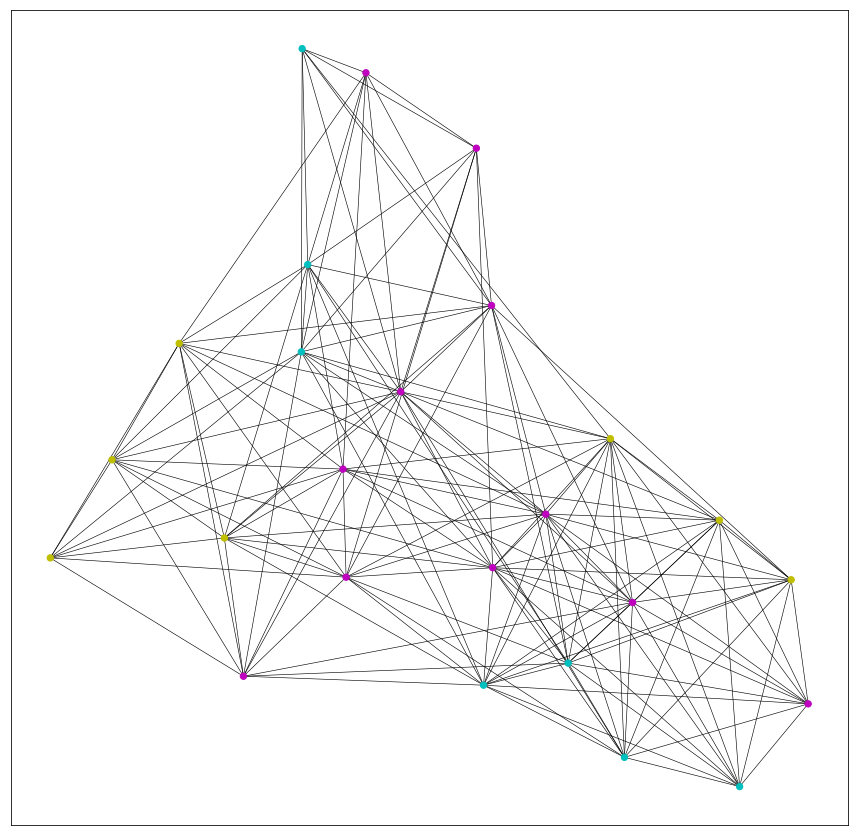

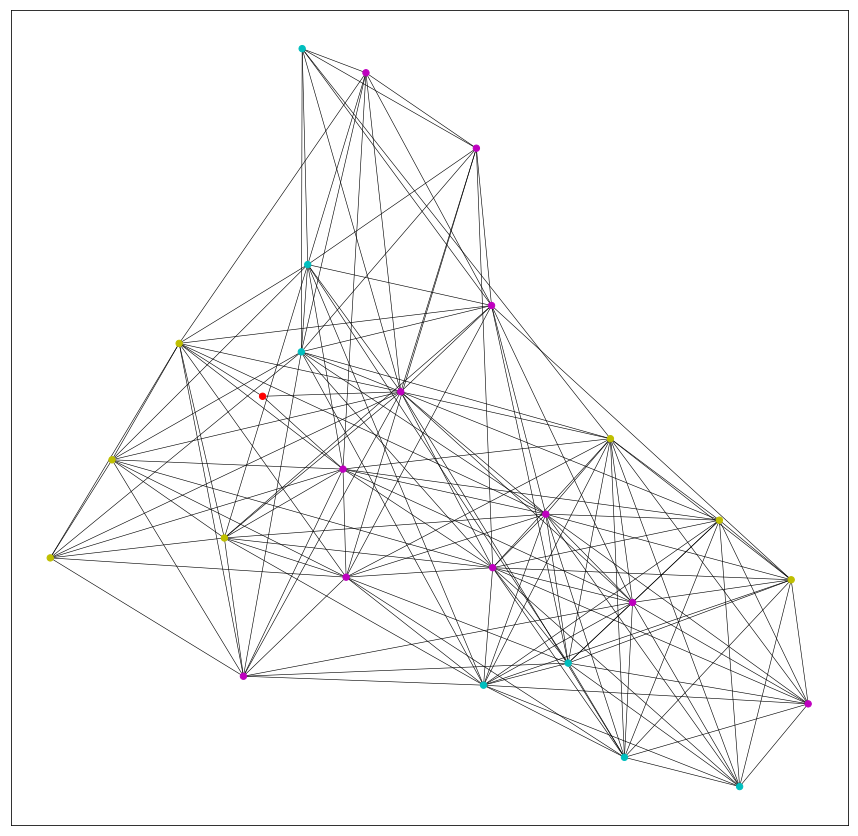

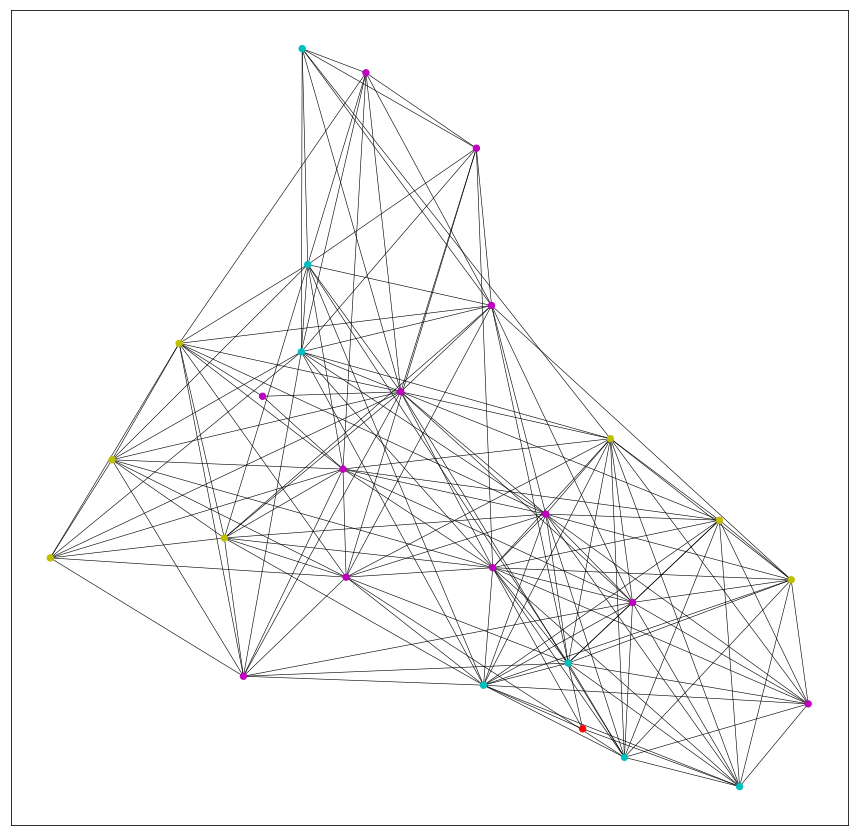

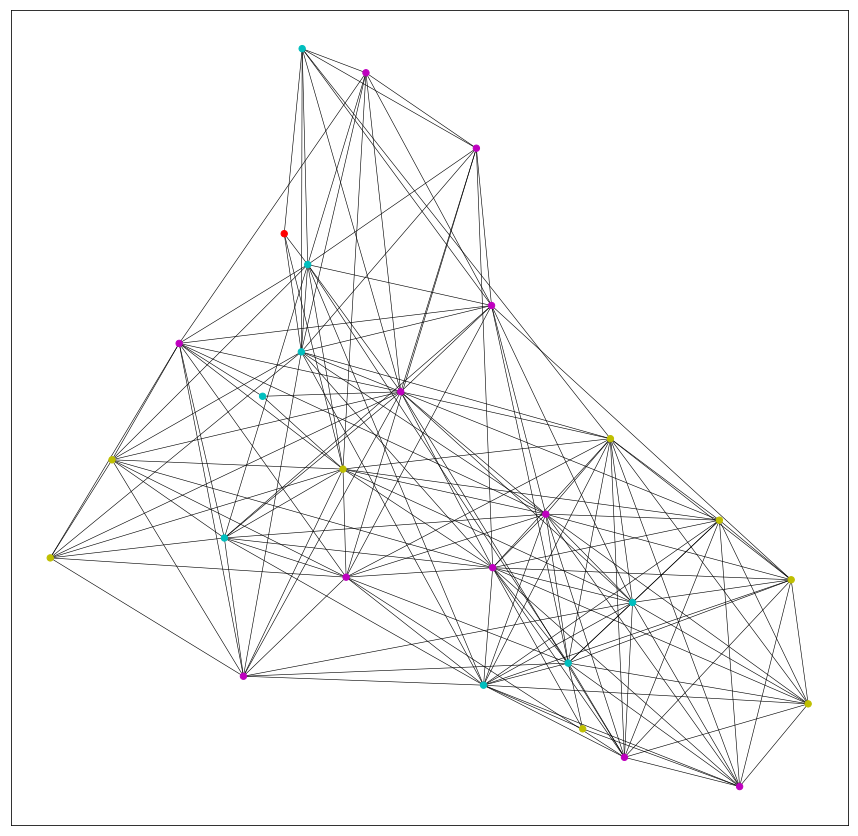

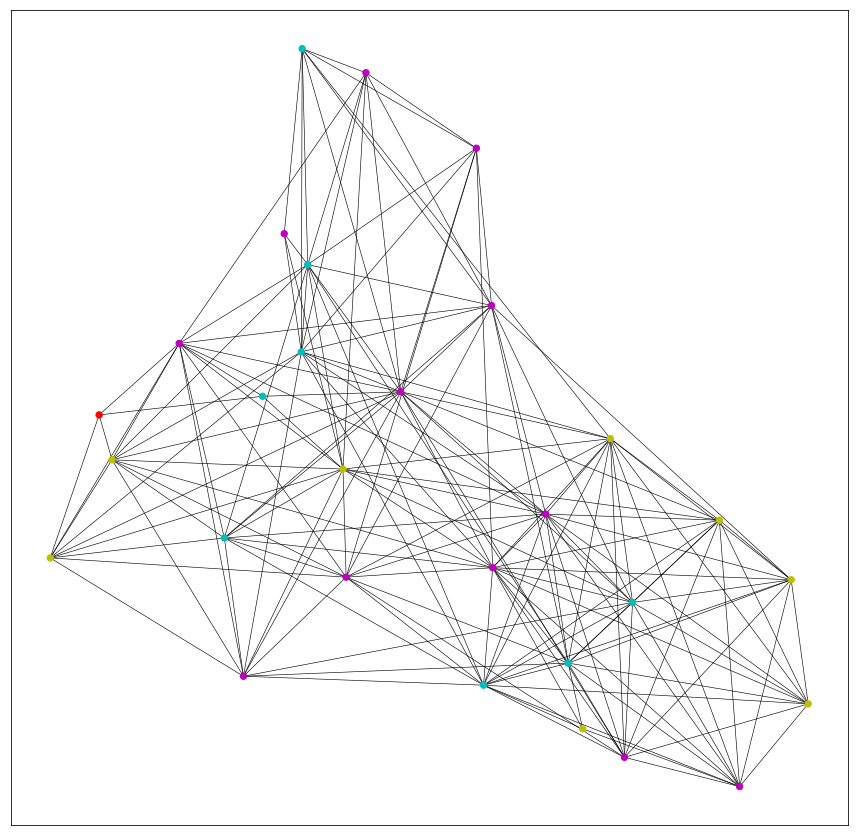

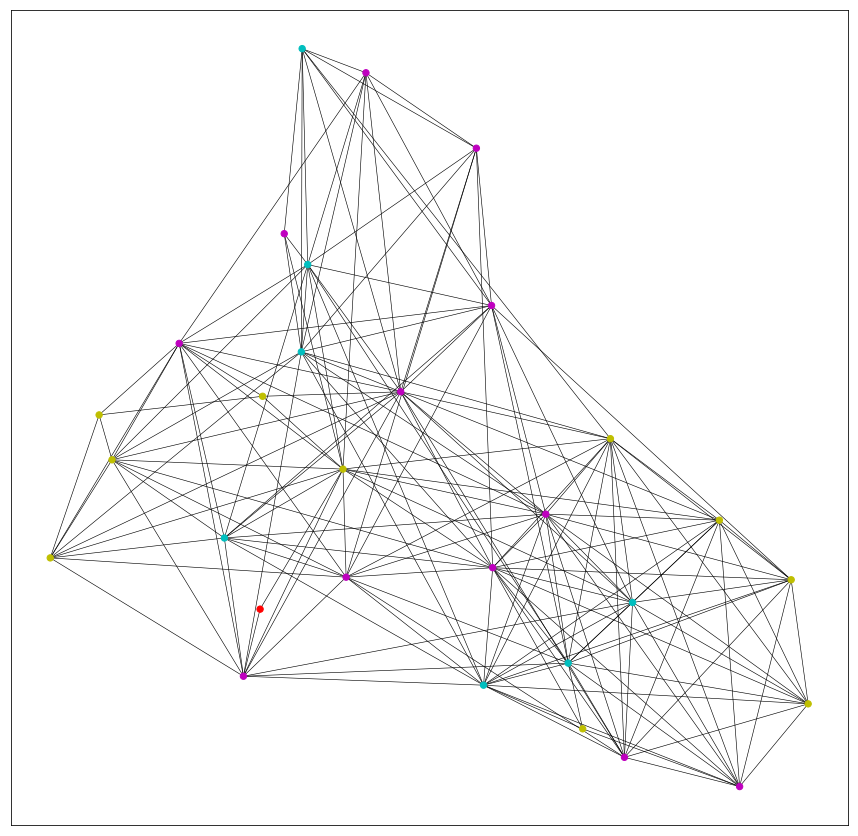

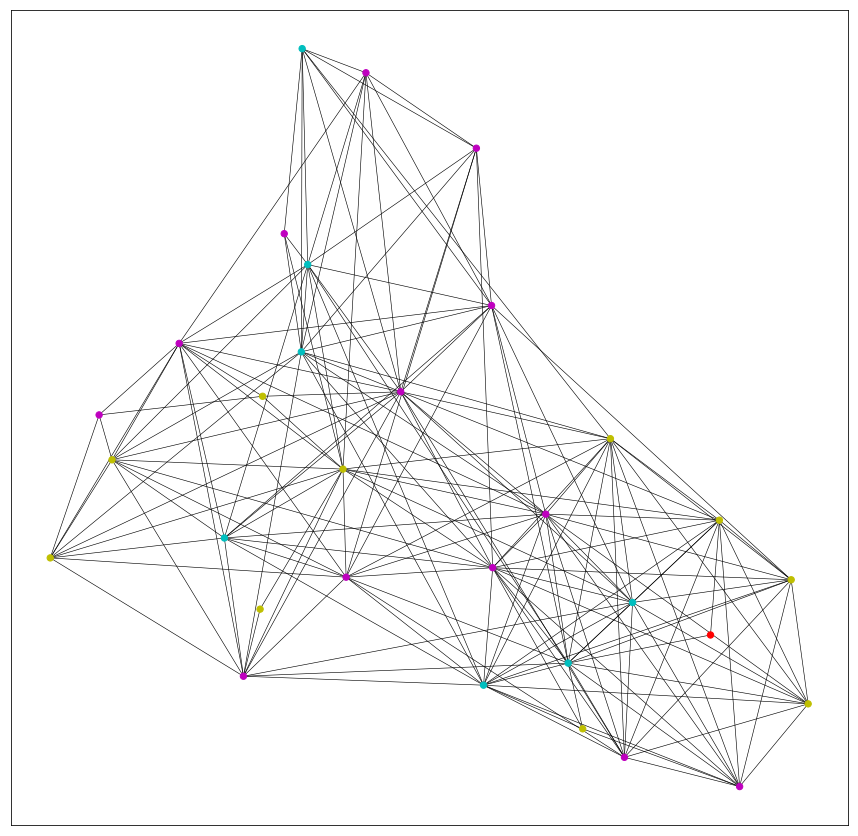

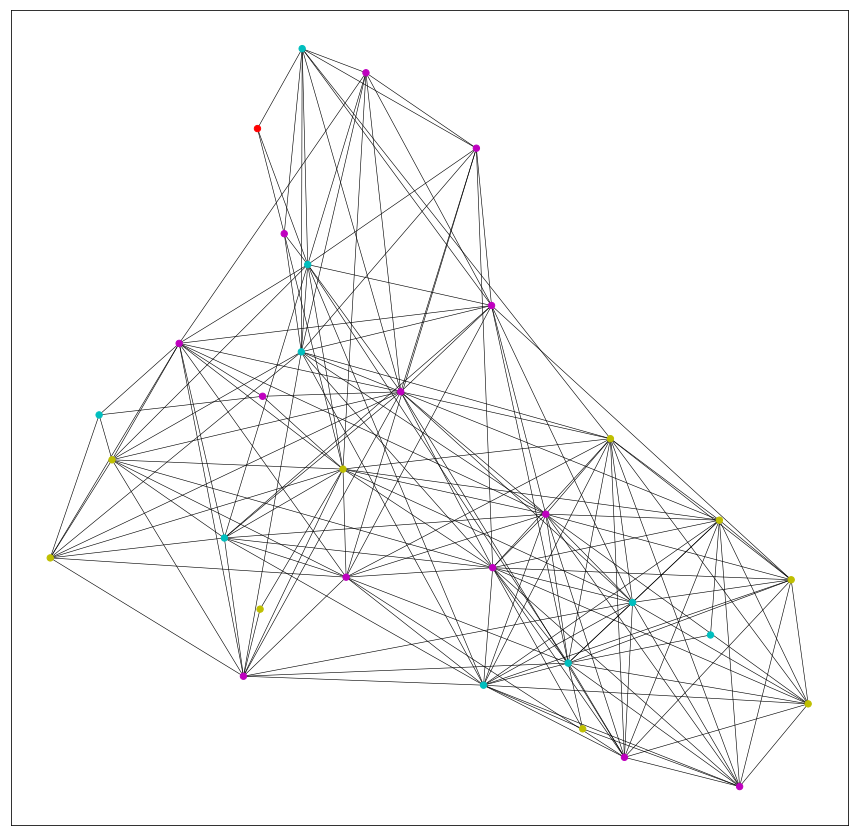

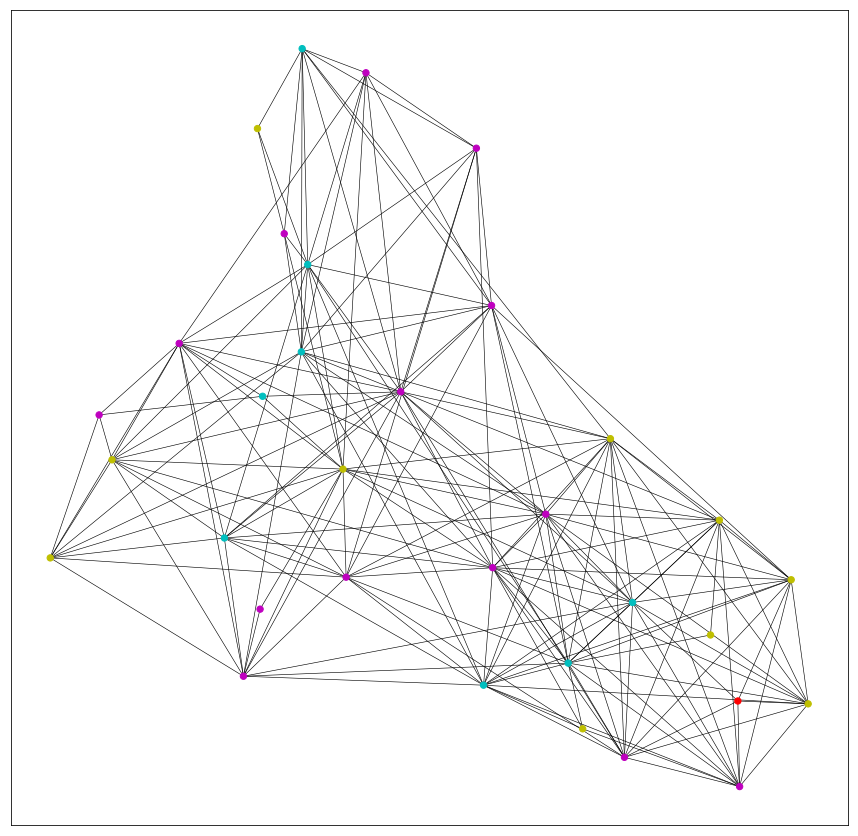

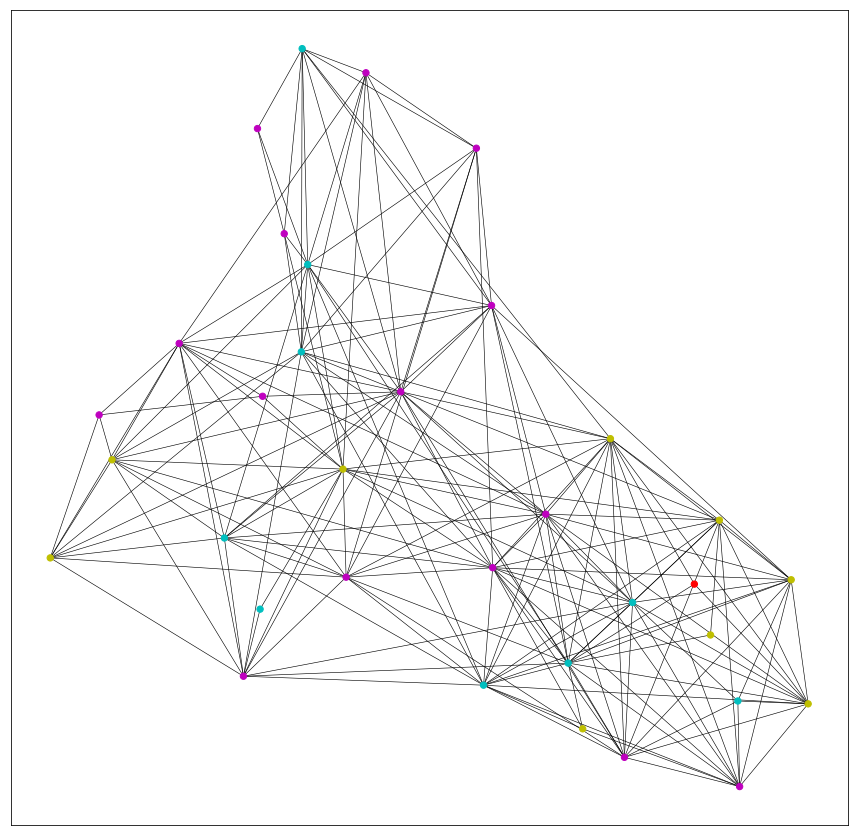

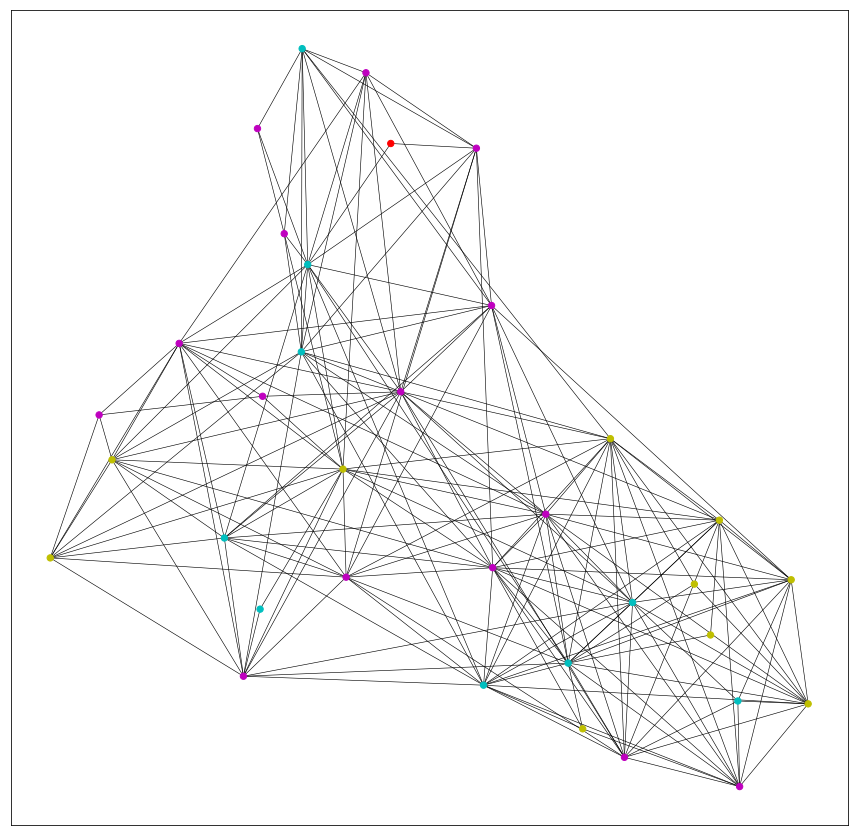

In [5]:
G_attr = attribute_block_graph(_N * _M)
G_attr_nx = gnx.graph_to_nx(G_attr)

G_attr_vtx_pos = nx.drawing.layout.spring_layout(G_attr_nx)
colors = [ _COLOR_LIST[G_attr.data[v]['g']] for v in G_attr.vertices ]

plt.figure(figsize=(15,15))
nx.draw_networkx(G_attr_nx, pos=G_attr_vtx_pos,
                 node_size=40, node_color=colors, width=0.6, with_labels=False)

new_vtxs = []

for i in range(10):
    prev_pos = G_attr_vtx_pos
    prev_nodes = G_attr_nx.nodes()
    
    nvtx = graph.Vertex(0, 0, {0 : 0}, _N * _M + i)
    init_vtx = add_attr_graph_vtx(G_attr, nvtx, _RW_LENGTH)
    
    G_attr_nx = gnx.graph_to_nx(G_attr)
    nvtx_idx = list(G_attr_nx.nodes()).index(nvtx)
    colors = [ _COLOR_LIST[G_attr.data[v]['g']] for v in G_attr.vertices ]
    colors[nvtx_idx] = 'r'
    prev_pos[nvtx] = prev_pos[init_vtx]
    G_attr_vtx_pos = nx.drawing.layout.spring_layout(G_attr_nx,
                                                     pos=prev_pos, fixed=prev_nodes)
    
    plt.figure(figsize=(15,15))
    nx.draw_networkx(G_attr_nx, pos=G_attr_vtx_pos,
                     node_size=40, node_color=colors, width=0.6, with_labels=None)
    
    new_vtxs.append(nvtx)